In [112]:
# Define the password variable
password = '*********'

In [113]:
import warnings
warnings.filterwarnings("ignore")

In [114]:
import mysql.connector
from mysql.connector import Error
import pandas as pd

# Create a dictionary to store the table names and their corresponding dataframes
dataframes = {}

try:
    connection = mysql.connector.connect(
        host='localhost', 
        user='root',
        password=password,
        database='project'
    )
    if connection.is_connected():
        db_Info = connection.get_server_info()
        print("Connected to MySQL Server version ", db_Info)
        cursor = connection.cursor()
        cursor.execute("select database();")
        record = cursor.fetchone()
        print("Your connected to database: ", record)

        # Retrieve data from table1 and create a dataframe
        table1_query = "SELECT * FROM products"
        df_products = pd.read_sql_query(table1_query, connection)
        dataframes['products'] = df_products

       # Retrieve data from table2 and create a dataframe
        table2_query = "SELECT * FROM customers"
        df_customers = pd.read_sql_query(table2_query, connection)
        dataframes['customers'] = df_customers

        # Retrieve data from table3 and create a dataframe
        table3_query = "SELECT * FROM geo_location"
        df_geo_location = pd.read_sql_query(table3_query, connection)
        dataframes['geo_location'] = df_geo_location
        
        # Retrieve data from table4 and create a dataframe
        table4_query = "SELECT * FROM items"
        df_items = pd.read_sql_query(table4_query, connection)
        dataframes['items'] = df_items
        
        # Retrieve data from table5 and create a dataframe
        table5_query = "SELECT * FROM orders"
        df_orders = pd.read_sql_query(table5_query, connection)
        dataframes['orders'] = df_orders
        
        # Retrieve data from table6 and create a dataframe
        table6_query = "SELECT * FROM payments"
        df_payments = pd.read_sql_query(table6_query, connection)
        dataframes['payments'] = df_payments
        
        # Retrieve data from table7 and create a dataframe
        table7_query = "SELECT * FROM reviews"
        df_reviews = pd.read_sql_query(table7_query, connection)
        dataframes['reviews'] = df_reviews
        
        # Retrieve data from table8 and create a dataframe
        table8_query = "SELECT * FROM sellers"
        df_sellers = pd.read_sql_query(table8_query, connection)
        dataframes['sellers'] = df_sellers
        
        print("Saved all tables to dataframe")

except Error as e:
    print("Error while connecting to MySQL", e)

finally:
    if (connection is not None) and (connection.is_connected()):
        connection.close()
        print("MySQL connection is closed")


Connected to MySQL Server version  8.0.32
Your connected to database:  ('project',)
Saved all tables to dataframe
MySQL connection is closed


In [ ]:
## 1. Orders placed every month

df_orders['placed_date'] = pd.to_datetime(df_orders.placed_date, format='%m/%d/%y %H:%M')
df_orders['Year_month'] = df_orders.placed_date.apply(lambda x: pd.Timestamp.strftime(x, '%Y-%m'))

In [ ]:
order_month = df_orders[['customer_id', 'Year_month']]

In [ ]:
orders_placed_every_month = order_month.groupby('Year_month')[['customer_id']].count()

# create a list of the outliers to remove
to_remove = [1, 4, 16]

# create a boolean mask for the rows to keep
keep_rows = ~orders_placed_every_month['customer_id'].isin(to_remove)

# select only the rows to keep
orders_placed_every_month = orders_placed_every_month[keep_rows]
orders_placed_every_month

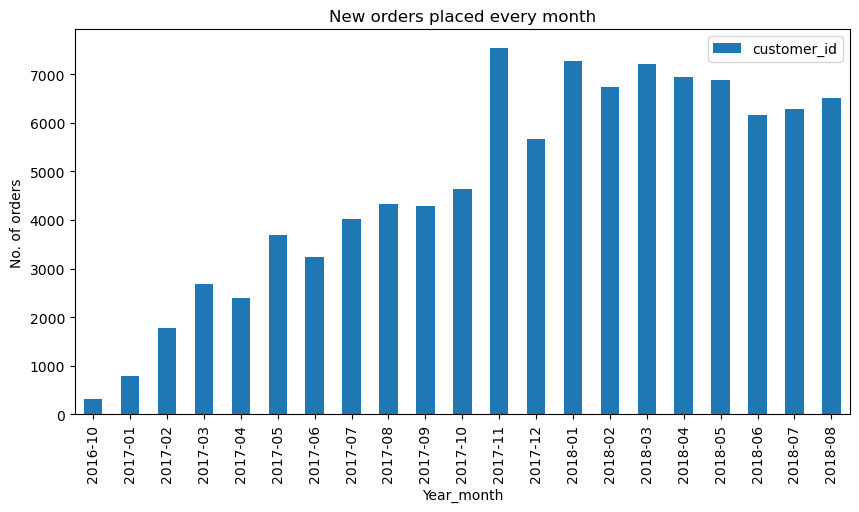

In [104]:
from matplotlib import pyplot as plt

orders_placed_every_month.plot(kind='bar',figsize=(10,5))
plt.ylabel('No. of orders')
plt.title('New orders placed every month')
plt.show()

In [ ]:
## 2. Monthly Revenue trends

df_items['shipping_limit_date'] = pd.to_datetime(df_items.shipping_limit_date, format='%m/%d/%y %H:%M')
df_items['Year_month'] = df_items.shipping_limit_date.apply(lambda x: pd.Timestamp.strftime(x, '%Y-%m'))

In [ ]:
revenue_month = df_items[['price', 'Year_month']]
revenue_month

In [ ]:
revenue_every_month = revenue_month.groupby('Year_month')[['price']].sum()
revenue_every_month

# create a list of the outliers to remove
to_remove = [194.47, 10.90, 14502.50, 145.98, 199.98]

# create a boolean mask for the rows to keep
keep_rows = ~revenue_every_month['price'].isin(to_remove)

# select only the rows to keep
revenue_every_month = revenue_every_month[keep_rows]
revenue_every_month

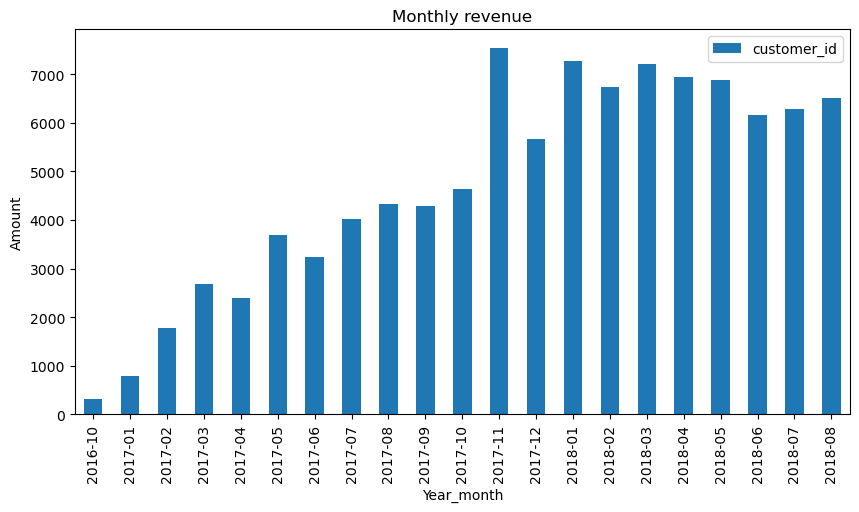

In [95]:
orders_placed_every_month.plot(kind='bar',figsize=(10,5))
plt.ylabel('Amount')
plt.title('Monthly revenue')
plt.show()

In [98]:
product_count = df_products.groupby('category').agg(Product_count=('product_id', 'count')).reset_index()
product_count = product_count.sort_values(by='Product_count', ascending=False)
product_count

,category,Product_count
8,Bed_Bath_Table,3029
66,Sports_Leisure,2867
40,Furniture_Decor,2657
44,Health_Beauty,2444
50,Housewares,2335
...,...,...
68,Tablets_Printing_Image,9
30,Fashion_Childrens_Clothes,5
47,Home_Comfort_2,5
62,Security_And_Services,2


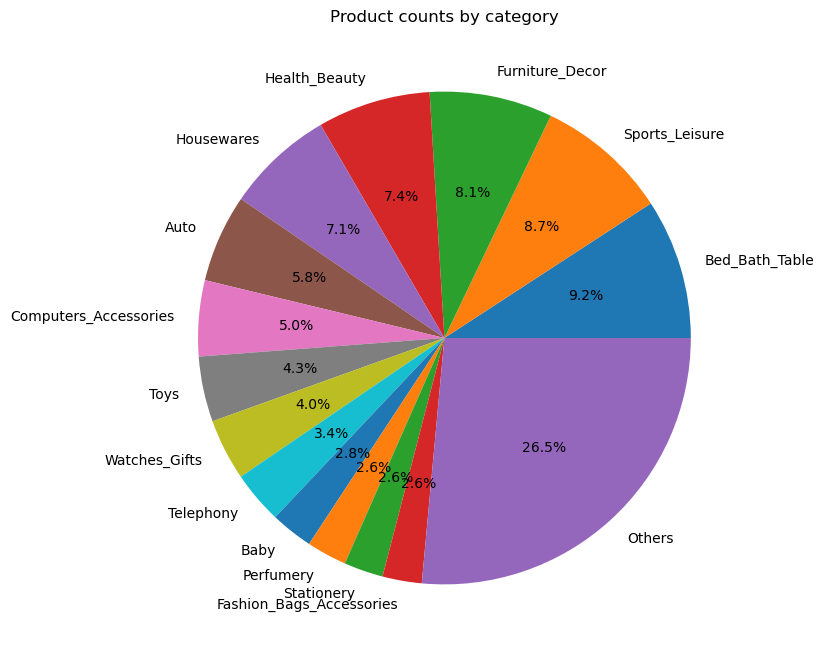

In [103]:
import matplotlib.pyplot as plt

# calculate the total number of products
total_count = product_count['Product_count'].sum()

# create a copy of the product_count dataframe
modified_count = product_count.copy()

# group categories with less than 2.5% of the total products count into a new "Others" category
others_count = modified_count[modified_count['Product_count']/total_count < 0.025]['Product_count'].sum()
modified_count = modified_count[modified_count['Product_count']/total_count >= 0.025]
modified_count.loc[len(modified_count)] = ['Others', others_count]

# create the pie chart
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
ax.pie(modified_count['Product_count'], labels=modified_count['category'], autopct='%1.1f%%')

# reduce the font size of the labels
plt.rcParams.update({'font.size': 10})

# add a title
plt.title('Products distribution across category')

# display the chart
plt.show()


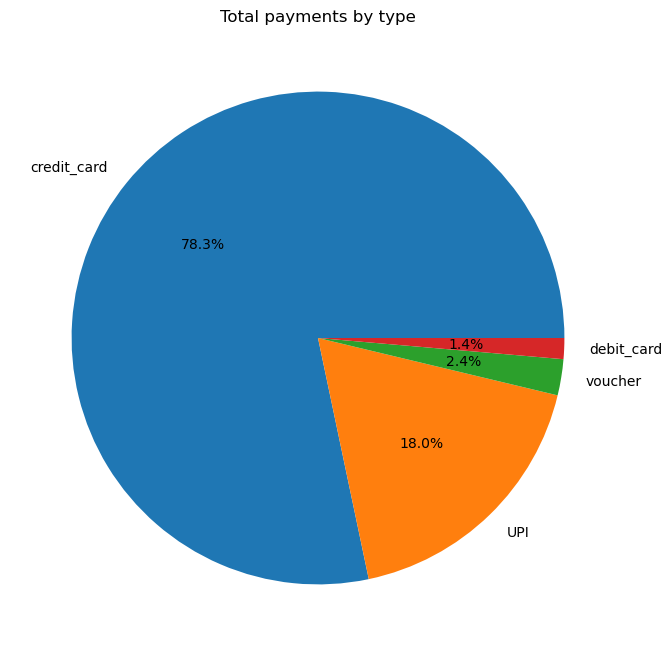

In [111]:
# group by 'type' and aggregate 'amount' by sum
payment_total = df_payments.groupby('type').agg(total=('amount', 'sum')).reset_index()

# sort by 'total' in descending order
payment_total = payment_total.sort_values(by='total', ascending=False)


# exclude rows with 'not_defined' type
payment_total = payment_total[payment_total['type'] != 'not_defined']

# create a figure with a bigger size
fig = plt.figure(figsize=(8, 8))

# create the pie chart
ax = fig.add_subplot(111)
ax.pie(payment_total['total'], labels=payment_total['type'], autopct='%1.1f%%')

# reduce the font size of the labels
plt.rcParams.update({'font.size': 10})

# add a title
plt.title('Total payments by type')

# display the chart
plt.show()
